# QSPICE Python Files Initialization

In [ ]:
import os
import shutil

# Get the current working directory (where your script is running)
current_dir = os.getcwd()

# Define the source folder (QSPICE_Parser is located above the project directory)
source_folder = os.path.join(os.path.dirname(current_dir), 'QSPICE_Parser')

# Define the source file path
source_file = os.path.join(source_folder, 'QSPICE_parser.py')

# Define the destination folder within the project (subfolder called QSPICE)
destination_folder = os.path.join(current_dir, 'QSPICE')

# Define the destination file path (within the QSPICE subfolder)
destination_file = os.path.join(destination_folder, 'QSPICE_parser.py')

# Copy the file from source to destination
shutil.copy(source_file, destination_file)

In [ ]:
from QSPICE import QSPICE_parser
import importlib
import sys

# reload QSPICE/Python parser without kernel restart
importlib.reload(QSPICE_parser)

#Create PyQSPICE file for input rectifier
QSPICE_parser.parse_and_generate_script('CCM_Boost_PFC_I-AVG.qsch','QSPICE_CCM_Boost_PFC_I_AVG.py')

# Delete parser script file from QSPICE folder
os.remove(destination_file)

In [ ]:
import math
import pandas as pd
import numpy as np

import CCM_Boost_PFC_QSPICE_circs

from IPython.display import display, Markdown, Latex
from matplotlib import pyplot as plt
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from scipy.interpolate import RegularGridInterpolator
from scipy.interpolate import interp1d

pd.options.display.float_format = '{:.5e}'.format


# 2D interpolation 
# path - path to data folder
# file_name - filename of csv file with EON/EFF data
# VDS - MOSFET VDS value
# ID - drain current
# note: current vector has to start from 0 up to value larger than maximum peak current
# note: voltage vector should start from 0 up to VDS_max
def ESW_Interp(path,file_name,VDS,ID):
    
    ESW=0
    if (VDS >= 0) and (file_name != ''):
        df = pd.read_csv(path+file_name, header=None)

        Y=df.iloc[1:len(df.index),0].to_numpy()

        X=df.iloc[0,1:].to_numpy()

        data=df.iloc[1:,1:].to_numpy()
   
        interp = RegularGridInterpolator((Y,X),data)
        ESW=interp((ID,VDS))
       
    else:
        ESW=0
    
    
    return ESW

# Switching Losses Calculation
# data - Pandas dataframe
# VDS - VDS value. In Boost PFC, VDS is equal to Vout

#return: Total energy in J over current waveform period
def ESW_Calc(data,VDS):
    
    #df = pd.read_csv(path+file_name)
    df = data
    # Modify the data so small numerical deviation from 0 and 1 will not interfere with TurnON/OFF detection
    # Tolerance range for modification. E.g. Value within range of 1 +/- tolerance is still concidered as 1
    tolerance=1e-4
    df['V(pwm)']=df['V(pwm)'].apply(lambda x: 1 if (1-tolerance) <= x <= (1+tolerance) else x)
    df['V(pwm)']=df['V(pwm)'].apply(lambda x: 0 if (0-tolerance) <= x <= (0+tolerance) else x)

    #Detect Turn-OFF (1->0)
    mask_OFF = (df['V(pwm)'] == 1) & (df['V(pwm)'].shift(-1) < 1)
    
    #Detect Turn-ON (0->1)
    mask_ON = (df['V(pwm)'] == 1) & (df['V(pwm)'].shift(1) < 1)

    # DataFrame of currents for Turn-OFF energy calculation
    I_OFF = df.loc[mask_OFF,['Time','I(S1)']]
    # Replace all negative current values by 0
    I_OFF['I(S1)'] = I_OFF['I(S1)'].apply(lambda x: max(0,x))
    
    # DataFrame of currents for Turn-ON energy calculation
    I_ON = df.loc[mask_ON,['Time','I(S1)']]
    # Replace all negative current values by 0
    I_ON['I(S1)'] = I_ON['I(S1)'].apply(lambda x: max(0,x))

    # Calculate and add EOFF column
    I_OFF['EOFF'] = ESW_Interp(MOS_DATA_FLD,EOFF_file_name,VDS,I_OFF['I(S1)'])

    # Calculate and add EON column
    I_ON['EON'] = ESW_Interp(MOS_DATA_FLD,EON_file_name,VDS,I_ON['I(S1)'])

    sum_EOFF = I_OFF['EOFF'].sum()
    sum_EON = I_ON['EON'].sum()
    E_tot = sum_EOFF + sum_EON

 #   print(I_OFF.to_string())
 #   print(I_ON.to_string())

 #   print('Total Eoff = ', sum_EOFF)
 #   print('Total Eon = ', sum_EON)
 #   print('Total ESW = ', E_tot)
       
    return E_tot


# Input Data

In [53]:
# Use simulation (True/False)
sim_on = True

#Input AC values in RMS
VAC_min = 195
VAC_max = 265
VAC_nom = 230

AC_freq=50

#Output Voltage
Vout=400
Vout_pp=20

#Output power 
#note: Concider that output power is Pout of DC/DC / eff_dc_dc
Pout=940
#Estimated efficiency
eff=0.96
#switching frequency
fsw=133e3

#Inductor ripple current (e.g. for 25% put 0.25)
IL_ripple=0.5

### Input REC Bridge Diode ####
REC_fwd = 1
REC_rdiff = 30e-3

### Input EMI Filter ###
#Additional total resistance formed by EMI components
#CM_Choke+Relay
R_EMI = 8e-3+0.1

### MOSFET ###
# Set MOSFET Data Folder and EOFF and EON file names. If empty string is provided, EOFF and EON energy estimation is skipped and return 0 J
# Note. EOFF and EON data should be obtained using a standard double-pulse test method using the actual boost diode.
MOS_DATA_FLD = "Data/MOSFET/IPP60R120P7/"
EOFF_file_name = "EOFF_15V_100degC_5600mOhm_25ns_IDH08G65C6.csv"
EON_file_name = "EON_15V_100degC_5600mOhm_25ns_IDH08G65C6.csv"

#WC RDSon@100degC
rdson=0.204

### Output Diode@75degC ###
# Infineon IDH08G65C6
BOOST_fwd=0.69
BOOST_rdiff=76e-3
BOOST_Qc = 12.2e-9

### Output Capacitor ###
Cout_ESR = 150e-3

### Current sense resistor
Rsense = 10e-3

################## Circuit Calculation for the purpose of QSPICE Simulation only


################### TESTING ########################


#print('EOFF Energy:',ESW_Interp(MOS_DATA_FLD,EOFF_file_name,400,[0.01, 11]))
#print('EON Energy:',ESW_Interp(MOS_DATA_FLD,EON_file_name,400,0.1))

# QSPICE_PFC_CCM_ACMC(VAC_rms, Cout, ESR, eff, fsw, freq, L, Pout, Vout)
#ret=CCM_Boost_PFC_QSPICE_circs.QSPICE_PFC_CCM_ACMC(250, 500e-6, 150e-3, 0.96, 65e3, 50, 295e-6, 900, 400)
#print(ret[1][0])

#E_results = ESW_Calc(ret[0],400)
#print(E_results)

#wfrm = ret[0]
#plt.plot(wfrm["Time"], wfrm["V(OUT)"])
#plt.show()

# Minimum Inductor Value Estimation (in uH)
Note: Valid at minimum Vin and full load. To maintain the same ripple at maximum Vin, inductance must be higher

In [3]:
L=1/IL_ripple*(VAC_min**2/Pout)*(1-math.sqrt(2)*VAC_min/Vout)*1/fsw

In [4]:
print(round(L*1e6))

189


# Maximum Allowed Pk-Pk Output Voltage Ripple (in V)
To ensure proper boost functionality, output voltage must be alwasy higher than input voltage

In [5]:
Vout_pp_max=Vout-VAC_max*math.sqrt(2)
print(round(Vout_pp_max,2))
if Vout_pp > Vout_pp_max:
    display(Markdown('<font size="6"> <span style="color:red"> Warning: Defined output pk-pk voltage ripple does not ensure proper boost functionality </span></font>'))

25.23


# Output Capacitor Requirements

## Minimum Capacitance (in uF)

In [6]:
Cout=Pout/(2*math.pi*AC_freq*Vout_pp*Vout)

In [7]:
round(Cout*1e6,2)

374.01

# Stress Analysis (Worst-Case Calculation)

## Input RMS Current (in A)

In [8]:
I_IN_RMS = Pout/(VAC_min*eff)
round(I_IN_RMS,1)

5.0

## Current Sense Resistor RMS Current (in A)

In [9]:
I_RSENSE_RMS = I_IN_RMS
round(I_RSENSE_RMS,1)

5.0

## Inductor Peak Current (in A)

In [10]:
IL_peak=math.sqrt(2)*(Pout/eff)/VAC_min*(1+IL_ripple/2)

In [11]:
round(IL_peak,1)

8.9

## Inductor RMS Current (in A)

In [12]:
IL_RMS=(Pout/eff)/VAC_min

In [13]:
round(IL_RMS,2)

5.02

## MOSFET RMS Current (in A)

In [14]:
I_FET_RMS=(Pout/eff)/VAC_min*math.sqrt(1-(8*math.sqrt(2)*VAC_min/(3*math.pi*Vout)))

In [15]:
round(I_FET_RMS,2)

3.23

## BOOST Diode AVG Current (in A)

In [16]:
I_BOOST_AVG = Pout/Vout

In [17]:
round(I_BOOST_AVG,2)

2.35

## BOOST Diode RMS Current (in A)

In [18]:
I_BOOST_RMS = Pout/(VAC_min*eff)*math.sqrt((8*math.sqrt(2)*VAC_min)/(3*math.pi*Vout))
round(I_BOOST_RMS,2)

3.84

## Output Capacitor RMS Current (in A)

In [19]:
I_Cout_RMS=math.sqrt((8*math.sqrt(2)*Pout**2/(3*math.pi*VAC_min*Vout))-Pout**2/Vout**2)

In [20]:
round(I_Cout_RMS,2)

2.84

## Output Capacitor Peak Voltage (in V)

In [21]:
V_Cout_MAX = Vout+Vout_pp/2
round(V_Cout_MAX,2)

410.0

## REC Diode AVG Current / per diode (in A)

In [22]:
I_REC_AVG=1/math.pi*math.sqrt(2)*(Pout/eff)/VAC_min
round(I_REC_AVG,2)

2.26

## REC Diode RMS Current / per diode (in A)

In [23]:
I_REC_RMS = math.sqrt(2)*(Pout/(eff*VAC_min))/2
round(I_REC_RMS,2)

3.55

# Stress Analysis (Worst-Case Simulation)

In [54]:
E_SW_FET = 0
if sim_on == True:
    # Circuit calcuation for purpose of QSPICE simulation
    # Multiplier current limit
    IMUL=300e-6
    #RCS set maximum inductor peak current limit
    RCS=round(Rsense*1.1*I_IN_RMS*math.sqrt(2)/IMUL)
    print(RCS)
    # QSPICE_PFC_CCM_ACMC(VAC_rms, Cout, ESR, eff, fsw, freq, L, Pout, Vout)
    results_sim=CCM_Boost_PFC_QSPICE_circs.QSPICE_PFC_CCM_ACMC(VAC_min, Cout, Cout_ESR, eff, fsw, AC_freq, L, Pout, Vout)
  #  print(results_sim[1])
    IL_RMS       = results_sim[1][0]
    IL_peak      = results_sim[1][1]
    I_FET_RMS    = results_sim[1][2]
    I_BOOST_AVG  = results_sim[1][3]
    I_BOOST_RMS  = results_sim[1][4]
    I_Cout_RMS   = results_sim[1][5]
    I_REC_AVG    = results_sim[1][6]
    I_REC_RMS    = results_sim[1][7]
    V_Cout_MAX   = results_sim[1][8]+results_sim[1][9]/2
    I_IN_RMS     = results_sim[1][10]
    I_RSENSE_RMS = results_sim[1][11]
    
    E_SW_FET = ESW_Calc(results_sim[0],Vout)

    wfrm = results_sim[0]

260


## Input RMS Current (in A)

In [25]:
round(I_IN_RMS,1)

5.0

## Current Sense Resistor RMS Current (in A)

In [26]:
round(I_RSENSE_RMS,1)

5.0

## Inductor Peak Current (in A)

In [27]:
round(IL_peak,1)

8.9

## Inductor RMS Current (in A)

In [28]:
round(IL_RMS,2)

5.02

## MOSFET RMS Current (in A)

In [29]:
round(I_FET_RMS,2)

3.23

## BOOST Diode AVG Current (in A)

In [30]:
round(I_BOOST_AVG,2)

2.35

## BOOST Diode RMS Current (in A)

In [31]:
round(I_BOOST_RMS,2)

3.84

## Output Capacitor RMS Current (in A)

In [32]:
round(I_Cout_RMS,2)

2.84

## Output Capacitor Peak Voltage (in V)

In [33]:
round(V_Cout_MAX,2)

410.0

## REC Diode AVG Current / per diode (in A)

In [34]:
round(I_REC_AVG,2)

2.26

## REC Diode RMS Current / per diode (in A)

In [35]:
round(I_REC_RMS,2)

3.55

# Losses Estimation

## Bridge Rectifier (in W)

In [36]:
P_REC=4*(I_REC_AVG*REC_fwd+REC_rdiff*I_REC_RMS**2)

In [37]:
round(P_REC,2)

10.55

## EMI Filter (in W)

In [38]:
P_EMI = R_EMI * I_IN_RMS**2
round(P_EMI,2)

2.72

## Boost Diode

### Conduction Losses (in W)

In [39]:
P_diode_cond=I_BOOST_AVG*BOOST_fwd + BOOST_rdiff * I_BOOST_RMS**2 
round(P_diode_cond,2)

2.74

### Switching Losses (in W)

In [40]:
P_diode_SW=Vout*BOOST_Qc*fsw

In [41]:
round(P_diode_SW,2)

0.65

This is not losses on diode but on FET which is already included due to DP test performed with actual diode. D_SW has been deleted from graph below. It still remains in total losses calculation. It requires verification. This should be true due to the capacitive character of QRR in SiC diode.

## MOSFET

### Conduction Losses (in W)

In [42]:
P_FET_Cond = rdson * I_FET_RMS**2
round(P_FET_Cond,2)

2.13

### Switching Losses (in W)

In [43]:
P_FET_SW = E_SW_FET*AC_freq
round(P_FET_SW,2)

0

## Output Capacitor (in W)

In [44]:
P_Cout = Cout_ESR * I_Cout_RMS**2
round(P_Cout,2)

1.21

## Current Sense Resistor (in W)

In [45]:
P_Rsense = Rsense*I_RSENSE_RMS**2
round(P_Rsense,2)

0.25

# Estimated Total Converter Losses Without Magnetic Losses

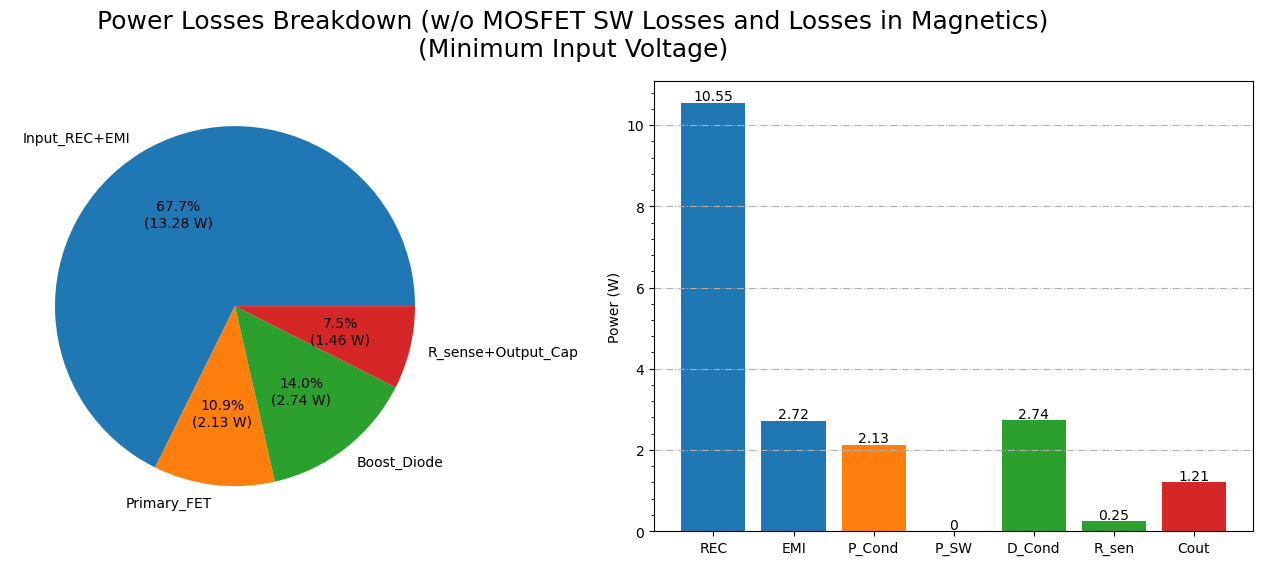

<font size="6"> <span style="color:red"> Warning: Primary MOSFET switching losses are available only when simulated.</span></font>

In [46]:
%matplotlib inline
labels_Ploss= 'Input_REC+EMI', 'Primary_FET', 'Boost_Diode', 'R_sense+Output_Cap'
data_Ploss = [P_REC+P_EMI, P_FET_Cond+P_FET_SW, P_diode_cond, P_Rsense+P_Cout]

labels_Ploss_Bar= 'REC', 'EMI', 'P_Cond', 'P_SW', 'D_Cond', 'R_sen', 'Cout'
data_Ploss_Bar = [P_REC, P_EMI, P_FET_Cond, P_FET_SW, P_diode_cond, P_Rsense, P_Cout]

#bar_labels = ['red', 'blue', '_red', 'orange','green']
bar_colors = ['tab:blue', 'tab:blue', 'tab:orange', 'tab:orange', 'tab:green', 'tab:green','tab:red', 'tab:red']

def autopct_format(values):
        def my_format(pct):
            total = sum(values)
            val = round(pct*total/100,3)
            return '{:.1f}%\n({v:.2f} W)'.format(pct, v=val)
        return my_format

def addlabels(x,y):
    for i in range(len(x)):
        ax2.text(i, y[i]+0.05, round(y[i],2), ha = 'center')
        

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(17,6))
#fig, ax1 = plt.subplots()

if sim_on == True:
    fig.suptitle('Power Losses Breakdown (w/o Losses in Magnetics)'+'\n'+'(Minimum Input Voltage)',fontsize=18)
else:
    fig.suptitle('Power Losses Breakdown (w/o MOSFET SW Losses and Losses in Magnetics)'+'\n'+'(Minimum Input Voltage)',fontsize=18)
ax1.pie(data_Ploss, labels=labels_Ploss, autopct=autopct_format(data_Ploss))

ax2.bar(labels_Ploss_Bar, data_Ploss_Bar,color=bar_colors)
ax2.grid(True, linestyle='-.',axis='y')
ax2.yaxis.set_minor_locator(AutoMinorLocator(5))
ax2.set_ylabel('Power (W)')
addlabels(labels_Ploss_Bar,data_Ploss_Bar)

fig.subplots_adjust(top=0.86)

plt.show()
if sim_on == False:
    display(Markdown('<font size="6"> <span style="color:red"> Warning: Primary MOSFET switching losses are available only when simulated.</span></font>'))

# Estimated Total Efficiency Without Magnetics (in %)

In [47]:
P_total = P_REC+P_EMI+P_FET_Cond+P_FET_SW+P_diode_cond+P_diode_SW+P_Rsense+P_Cout
eff_Vin_min = Pout / (Pout+P_total)
round(eff_Vin_min*100,1)

97.9

In [48]:
if eff > eff_Vin_min:
    display(Markdown('<font size="6"> <span style="color:red"> Warning: User estimated efficiency is bigger than calculated. The results are underestimated.</span></font>'))

# Selected Waveforms

In [49]:
if sim_on == True:
    %matplotlib ipympl
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13,5))
    #fig.suptitle('Power Losses Breakdown (w/o Losses in Magnetics)'+'\n'+'(Minimum Input Voltage)',fontsize=18)
    #ax1.pie(data_Ploss, labels=labels_Ploss, autopct=autopct_format(data_Ploss))
    ax1.plot(wfrm["Time"], wfrm["V(OUT)"])
    ax1.grid(True, linestyle='-.')
    ax1.set(xlabel='Time (s)', ylabel='Output Voltage (V)')
    ax2.plot(wfrm["Time"], wfrm["I(L1)"])
    ax2.grid(True, linestyle='-.')
    ax2.set(xlabel='Time (s)', ylabel='Inductor Current (A)')
    plt.show()
else:
    display(Markdown('<font size="6"> <span style="color:red"> Warning: Available only when simulated.</span></font>'))

<font size="6"> <span style="color:red"> Warning: Available only when simulated.</span></font>

# PFC Inductor Design

Based on M. Pieniz, J. R. Pinheiro and H. L. Hey, "An investigation of the boost inductor volume applied to PFC converters," 2006 37th IEEE Power Electronics Specialists Conference, Jeju, Korea (South), 2006, pp. 1-7, doi: 10.1109/pesc.2006.1712248.

It utilized low cost powder core material with a single layer coil


In [50]:
#Maximum wire current density in A/cm^2
j_max = 600

# Minimum wire cross-section in cm^2
S_min = IL_RMS / 600

#Minimum wire diameter in cm
dw_min = math.sqrt(4*S_min/math.pi)

#Minimum wire size in AWG
AWG_min = round(-39*math.log(dw_min*10/0.127,92)+36)
#Core Outside Diameter
OD = 50

## Minimum Wire Diameter

In [51]:
print(S_min*100)
print(dw_min)
print(AWG)

0.8368945868945871
0.1032263184855968


NameError: name 'AWG' is not defined

In [ ]:
N_max = 0.95*math.pi*((OD/(dw*kd))-1)